In [18]:
# Installations

In [19]:
! pip install emoji

In [20]:
! pip install openai

In [21]:
! pip install tqdm

In [22]:
! pip install scikit-learn

In [23]:
! pip install pandas

In [24]:
! pip install matplotlib

In [25]:
! pip install seaborn

In [26]:
# Imports

In [27]:
import pandas as pd
import emoji
from openai import OpenAI
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline

In [28]:
# Configurations

In [41]:
OPENAI_API_KEY = "YOUR_KEY"

openai_client = OpenAI(api_key=OPENAI_API_KEY)

In [30]:
# Get a list of all unicode emoji
all_emoji = list(emoji.EMOJI_DATA.keys())

In [31]:
# Embed the emoji using OpenAI
emoji_embeddings = []
for em in tqdm(all_emoji):
    embedding = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=em,
    )
    emoji_embeddings.append(embedding.data[0].embedding)

emoji_df = pd.DataFrame(emoji_embeddings)
emoji_df.head()

100%|███████████████████████████████████████| 5042/5042 [21:08<00:00,  3.98it/s]


,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,0.005884,0.006340,0.036018,0.004463,0.029079,-0.018194,0.015159,0.038611,-0.025346,-0.025375,...,-0.000998,-0.000846,-0.007758,0.005140,0.022882,0.018878,-0.003626,-0.014704,-0.012730,-0.000482
1,-0.023098,-0.024332,0.013816,0.038362,0.005818,-0.043808,0.004242,0.048180,-0.004058,-0.020992,...,0.002049,0.009336,-0.025002,-0.030394,0.048207,0.030126,0.027068,-0.014728,-0.001802,0.032406
2,-0.000488,0.000809,0.003596,0.048749,0.007074,-0.024789,-0.000547,0.057536,0.015615,-0.021698,...,0.019179,-0.000194,0.007528,-0.011980,0.024775,0.021970,0.008616,0.006369,0.042022,0.002487
3,0.002771,-0.005404,0.018383,0.005640,-0.023817,0.005647,-0.001136,0.052364,0.013855,-0.022125,...,-0.024536,0.025104,0.020583,0.003155,0.022006,0.045568,0.056885,-0.009745,-0.003471,0.006886
4,-0.022500,0.040246,0.003730,0.017008,-0.023917,0.017702,0.002875,0.034960,-0.011169,-0.064547,...,-0.011752,-0.012077,-0.016978,0.012645,0.031949,0.026634,0.023548,-0.032126,0.001656,0.004407


In [32]:
# Creating silhouette for different values of k in KMeans
silhouette_scores = []
k_options = list(range(5, 100, 5))

for k in k_options:
    # Clustering with k-means
    kmeans = KMeans(n_init=10, n_clusters=k, random_state=10)
    cluster_labels = kmeans.fit_predict(emoji_df)

    # Silhouette values
    score = silhouette_score(emoji_df, cluster_labels)
    silhouette_scores.append(score)

<Axes: >

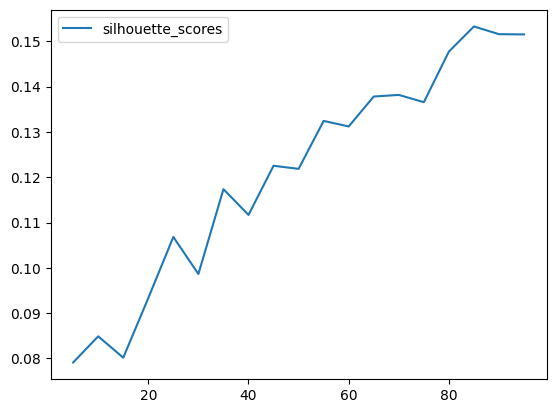

In [33]:
# Plot the silhouette scores
silhouette_df = pd.DataFrame({"silhouette_scores":silhouette_scores}, index=k_options)
silhouette_df.plot()

In [34]:
# Identify the best value of K
best_k = silhouette_df.idxmax()
print(f"Best K value: {best_k.values}")

Best K value: [85]


In [35]:
# Retrain KMeans on the best K value
kmeans = KMeans(n_init=10, n_clusters=best_k[0], random_state=10)
cluster_labels = kmeans.fit_predict(emoji_df)

In [36]:
# Get a PCA of the data to visualize
pca = PCA(n_components=2)
pca_result = pca.fit_transform(emoji_df)

In [37]:
# Construct the results dataframe
emoji_pca = pd.DataFrame(pca_result)
emoji_pca['cluster'] = cluster_labels
emoji_pca['emoji'] = all_emoji
emoji_pca.columns = ["pc1", "pc2", "cluster", "emoji"]
emoji_pca.head()

,pc1,pc2,cluster,emoji
0,-0.313822,-0.134772,48,🥇
1,-0.287390,-0.116748,48,🥈
2,-0.300122,-0.098153,48,🥉
3,-0.218608,-0.067239,2,🆎
4,-0.225269,0.004012,28,🏧


In [38]:
# Name the clusters using ChatGPT
cluster_names = {}
system_prompt = "You are an expert emoji group labeler. You will be given a list of emoji and will come up with a name for that group of emoji that is less than 5 words long."

for cluster in tqdm(emoji_pca.cluster.unique()):
    cluster_emojis = " ".join(emoji_pca[emoji_pca['cluster'] == cluster].emoji.values)
    
    completion = openai_client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": cluster_emojis}
      ]
    )
    
    cluster_names[cluster] = completion.choices[0].message.content

100%|███████████████████████████████████████████| 85/85 [00:48<00:00,  1.77it/s]


In [39]:
# Save the results
emoji_pca['label'] = emoji_pca.cluster.map(cluster_names)
emoji_pca.to_csv('emoji_groups.csv', index=False)
emoji_pca.head()

,pc1,pc2,cluster,emoji,label
0,-0.313822,-0.134772,48,🥇,"""Mixed Bag of Emotions"""
1,-0.287390,-0.116748,48,🥈,"""Mixed Bag of Emotions"""
2,-0.300122,-0.098153,48,🥉,"""Mixed Bag of Emotions"""
3,-0.218608,-0.067239,2,🆎,Symbolic Expressions and Icons
4,-0.225269,0.004012,28,🏧,🏞️🏗️🏡🏙️🏛️🏟️🏖️🏰🏯🏠🏩🏚️🏝️🏜️🏦🏥🏨🏪🏬🏛️🏢🏫🏭🏟️🏎️🏍️🏏🏀🏈🏉🏓🏸🏒...


/var/folders/pz/dhpfbgn152n3m_33zvb3kzzc0000gn/T/ipykernel_55561/1977966376.py:28: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/pz/dhpfbgn152n3m_33zvb3kzzc0000gn/T/ipykernel_55561/1977966376.py:28: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/pz/dhpfbgn152n3m_33zvb3kzzc0000gn/T/ipykernel_55561/1977966376.py:28: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from current font.
  plt.tight_layout()
/var/folders/pz/dhpfbgn152n3m_33zvb3kzzc0000gn/T/ipykernel_55561/1977966376.py:28: UserWarning: Glyph 127374 (\N{NEGATIVE SQUARED AB}) missing from current font.
  plt.tight_layout()
/var/folders/pz/dhpfbgn152n3m_33zvb3kzzc0000gn/T/ipykernel_55561/1977966376.py:28: UserWarning: Glyph 127975 (\N{AUTOMATED TELLER MACHINE}) missing from current font.
  plt.tight_layout()
/var/folders/pz/dhpfbgn152n3m_33zvb3kzzc0000gn/T/ipykernel_55561/1977966376.py:28: Us

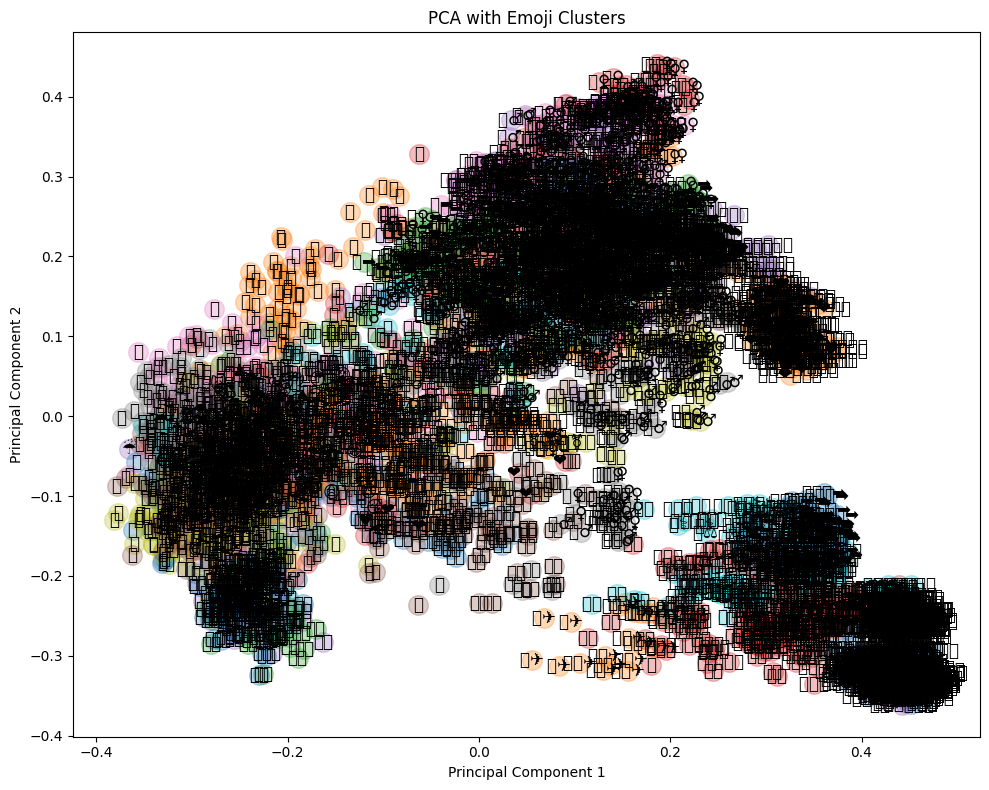

In [40]:
# Set the path to the Apple Color Emoji font on macOS (to visualize emoji using matplotlib)
prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')
plt.rcParams['font.family'] = prop.get_family()

# Create a scatter plot of the first and second principal components with emoji annotations
plt.figure(figsize=(10, 8))

# Define cluster colors using a color palette
cluster_colors = sns.color_palette("tab10", n_colors=emoji_pca['cluster'].nunique())

# Plot the background cluster colors
for cluster_id in emoji_pca['cluster'].unique():
    cluster_data = emoji_pca[emoji_pca['cluster'] == cluster_id]
    plt.scatter(cluster_data['pc1'], cluster_data['pc2'], 
                label=cluster_data['label'], 
                color=cluster_colors[cluster_id], alpha=0.3, s=200)

# Plot the emojis as annotations
for i, row in emoji_pca.iterrows():
    plt.text(row['pc1'], row['pc2'], row['emoji'], fontsize=12, ha='center', va='center')

# Add labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA with Emoji Clusters")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()